# Link Prediction

Note: taskRelations changed to taskStatusRelations (instantiates, runs, completes, ....), taskDataRelations (creates, references, validates, ...) and accessRelations (allocates, ...)

# Imports

In [1]:
import pandas as pd
import seaborn as sns

import networkx as nx
import numpy as np
from sklearn.pipeline import make_pipeline
import karateclub
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import dgl

from util import cv_score_link_prediction
from link_prediction import LinkPredictor, LinkPredictionWrapper, LinkDecoderModule, NetworkxLinkPredictor,\
NeighTypeVectorizer, CentralityTransformer

/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
Using backend: pytorch


# Data Acquisition

In [2]:
g = nx.read_gml("team_ip_1.gml")

# Baselines

## Dummy Classifier

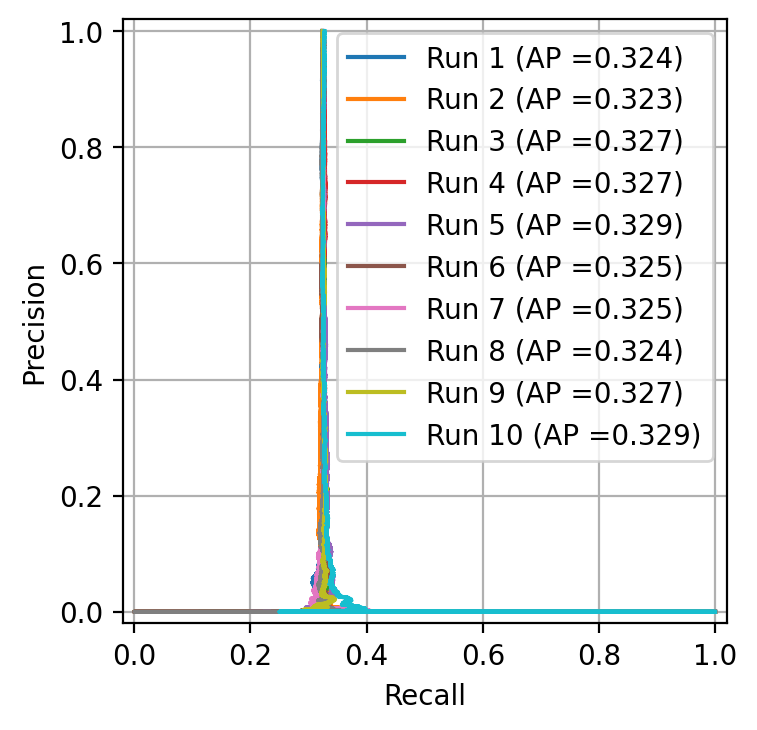

                          mean    std
average_precision_score  0.324  0.002
roc_auc_score            0.499  0.003


In [5]:
from sklearn.dummy import DummyClassifier

class DummyLinkPred():
    def fit(self, *_, **__):
        return self
    
    def predict_proba(self, X, X_test):
        return np.random.uniform(0, 1, size=X_test.number_of_edges())
    
    def predict(self, X, X_test):
        return self.predict_proba(X, X_test) >= 0.5
                

cv_score_link_prediction(DummyLinkPred(), g, plot_pr_curve=True);

## Topological Algorithms

resource_allocation_index


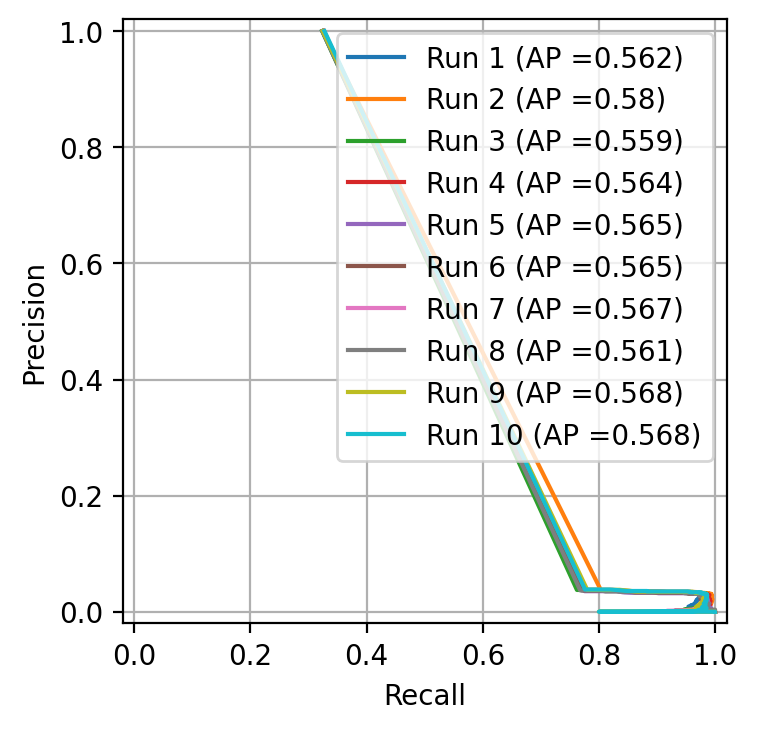

                          mean    std
average_precision_score  0.349  0.002
roc_auc_score            0.516  0.000
jaccard_coefficient


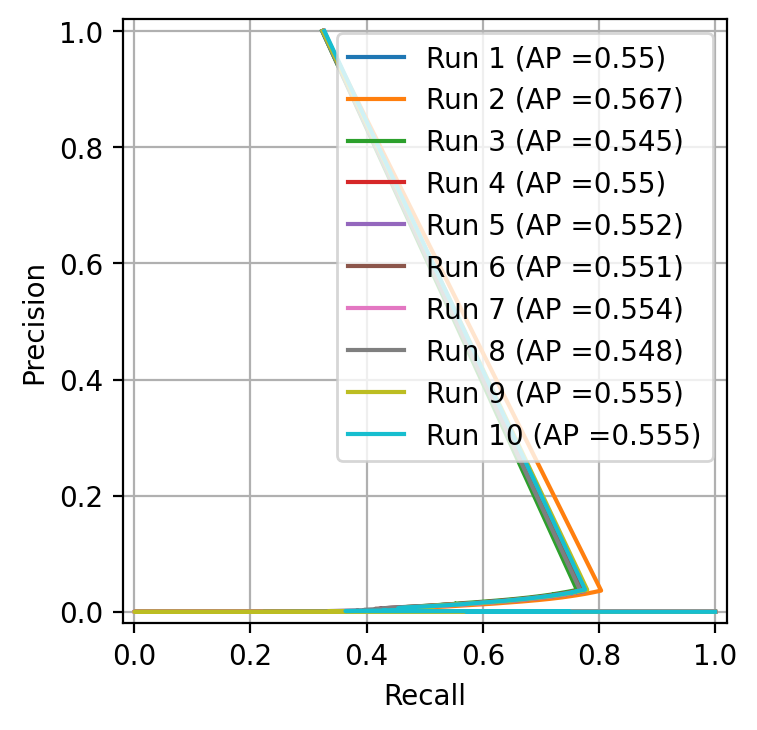

                          mean    std
average_precision_score  0.336  0.002
roc_auc_score            0.516  0.000
adamic_adar_index


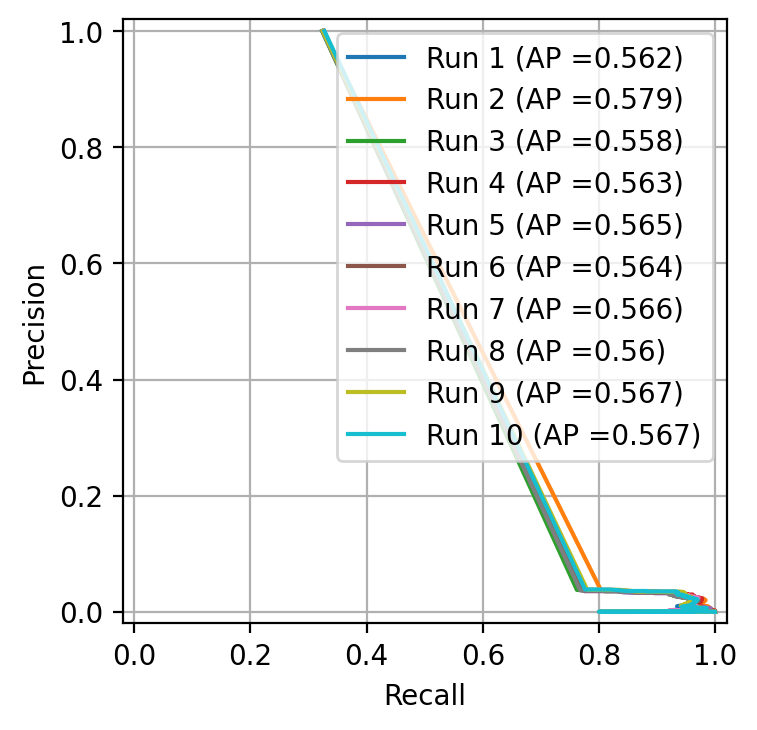

                          mean    std
average_precision_score  0.348  0.002
roc_auc_score            0.516  0.000
preferential_attachment


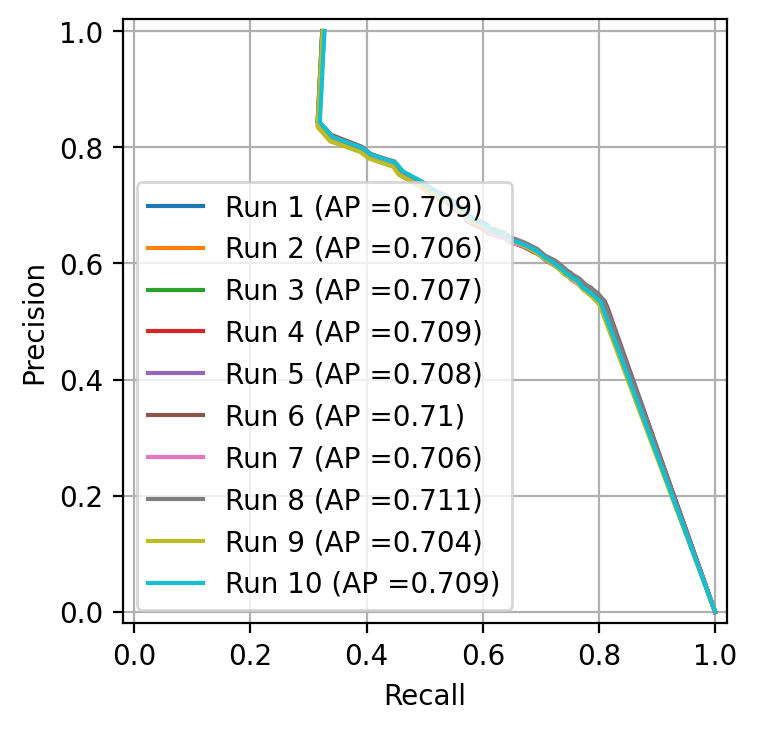

                          mean    std
average_precision_score  0.654  0.003
roc_auc_score            0.737  0.002


In [10]:
for algorithm in (nx.resource_allocation_index, nx.jaccard_coefficient, nx.adamic_adar_index,
                 nx.preferential_attachment):
    print(algorithm.__name__)
    nx_pred = NetworkxLinkPredictor(algorithm=algorithm, verbose=False)
    cv_score_link_prediction(nx_pred, g, verbose=False, plot_pr_curve=True);

## Bag of Types

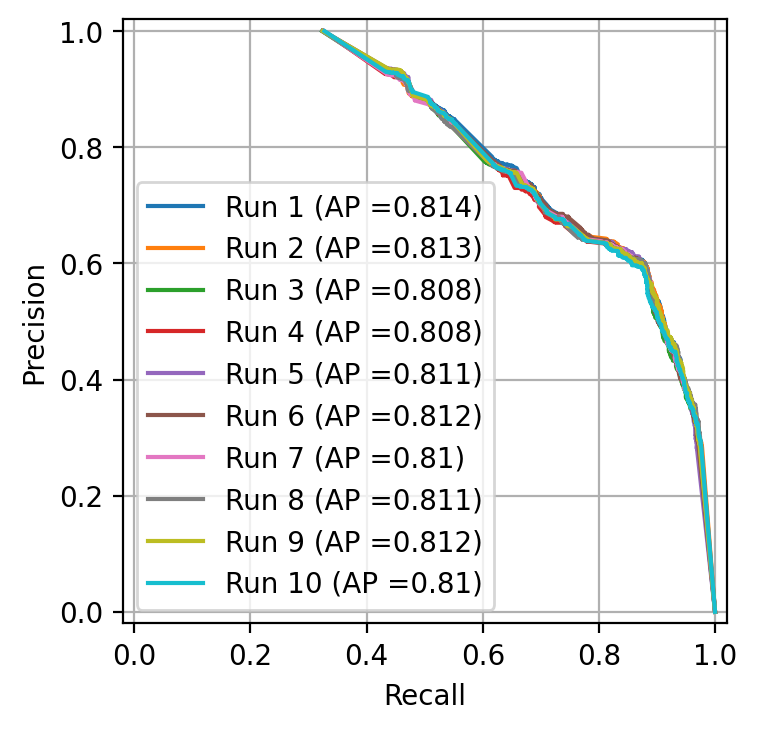

                          mean    std
average_precision_score  0.801  0.002
roc_auc_score            0.858  0.002


In [11]:
node_embedder = make_pipeline(NeighTypeVectorizer(), StandardScaler())
bot_rf = LinkPredictionWrapper(encoder=node_embedder)
bot_rf_scores = cv_score_link_prediction(bot_rf, g, plot_pr_curve=True);

## Walk-based Embeddings

DeepWalk


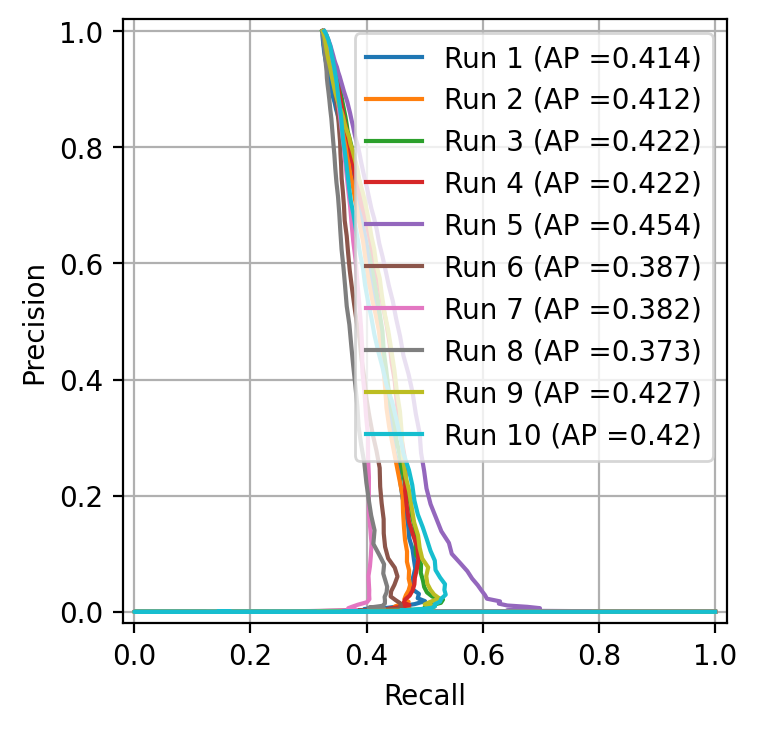

                          mean    std
average_precision_score  0.399  0.025
roc_auc_score            0.598  0.028
NodeSketch


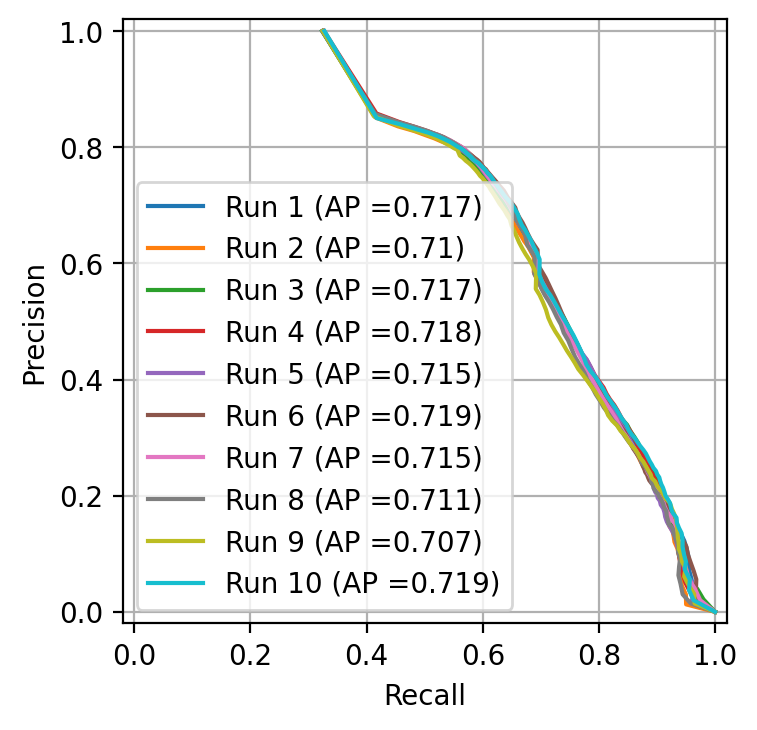

                          mean    std
average_precision_score  0.705  0.004
roc_auc_score            0.800  0.002
RandNE


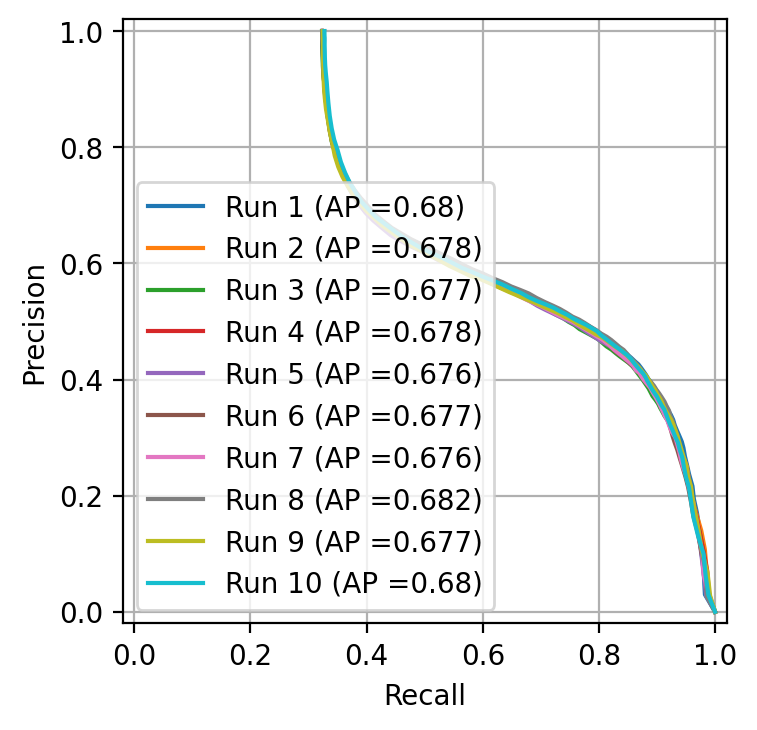

                          mean    std
average_precision_score  0.675  0.002
roc_auc_score            0.701  0.002
NetMF


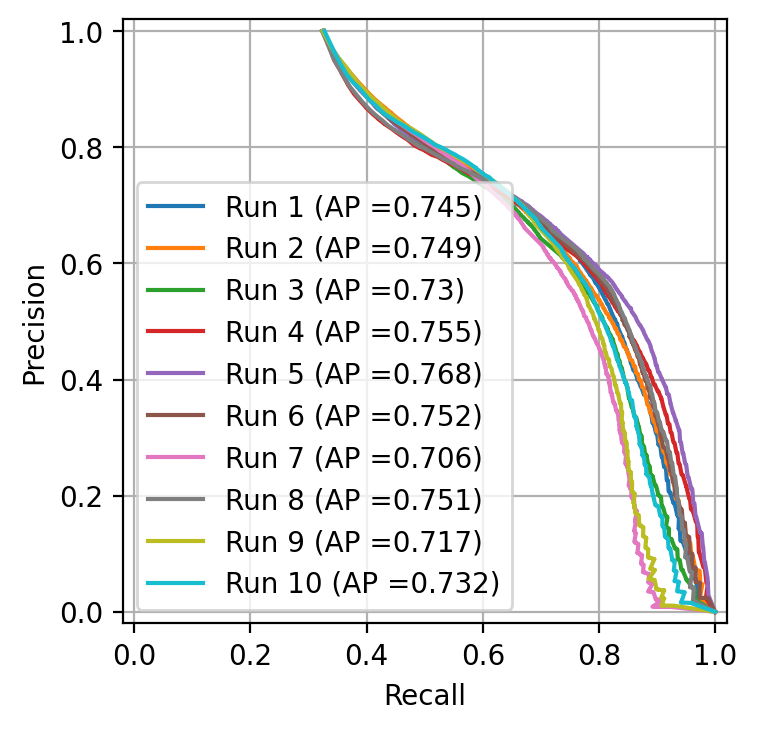

                          mean    std
average_precision_score  0.738  0.019
roc_auc_score            0.809  0.004
BoostNE


/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, 

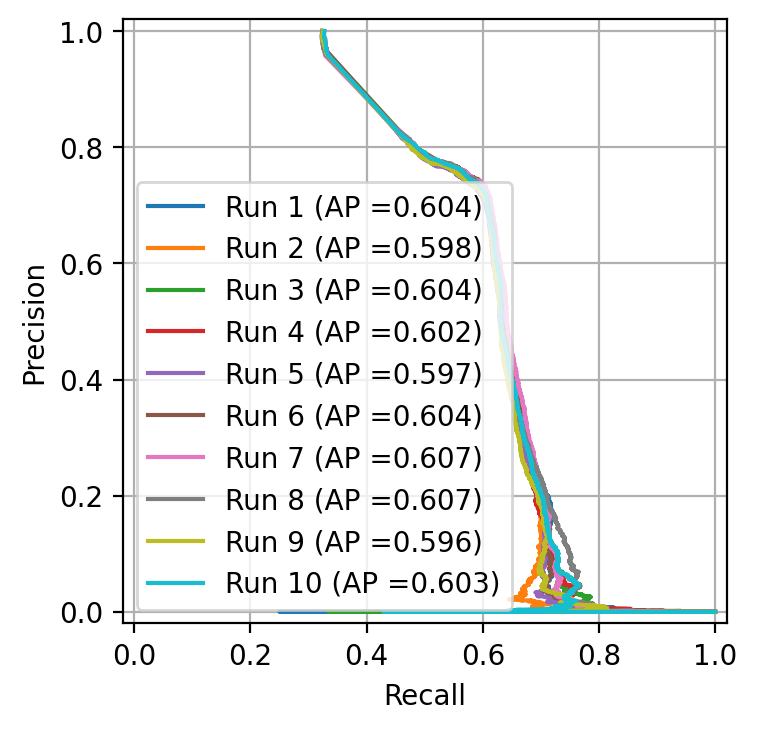

                          mean    std
average_precision_score  0.593  0.004
roc_auc_score            0.761  0.003


In [12]:
for algo in (karateclub.DeepWalk, karateclub.NodeSketch, karateclub.RandNE, karateclub.NetMF,
             karateclub.BoostNE, ):
    print(algo.__name__)
    pred = LinkPredictionWrapper(encoder=nn.KarateclubTransformer(algo()))
    cv_score_link_prediction(pred, g, plot_pr_curve=True)

# GCN Models

## Architecture Modalities

### GCN

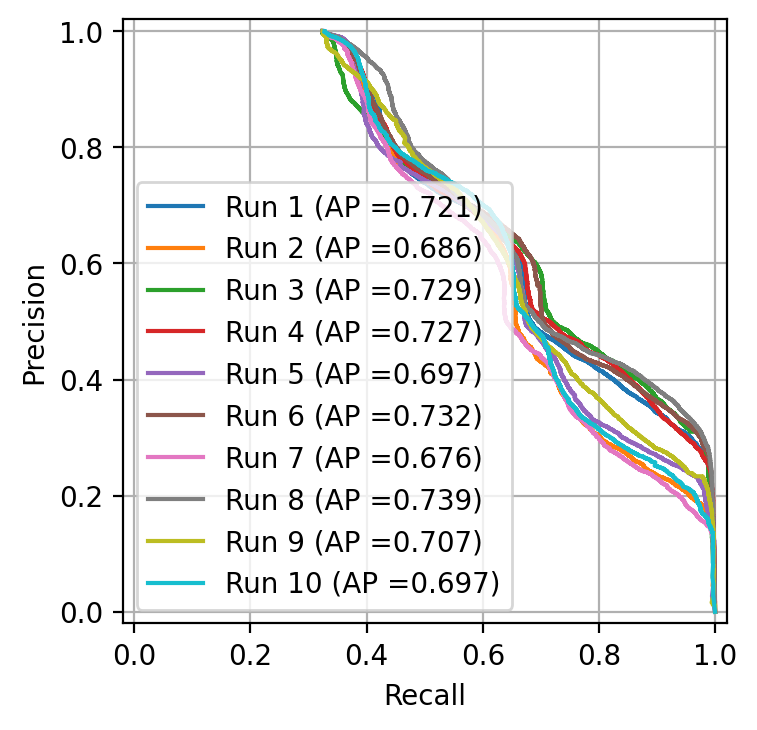

                          mean    std
average_precision_score  0.711  0.022
roc_auc_score            0.785  0.012


In [4]:
gcn = LinkPredictor(conv_cls=dgl.nn.GraphConv, skip_connections=False,
                                   decoder=LinkDecoderModule(asymmetric=False))

gcn_scores = cv_score_link_prediction(gcn, g, verbose=False, plot_pr_curve=True);

### A-GCN

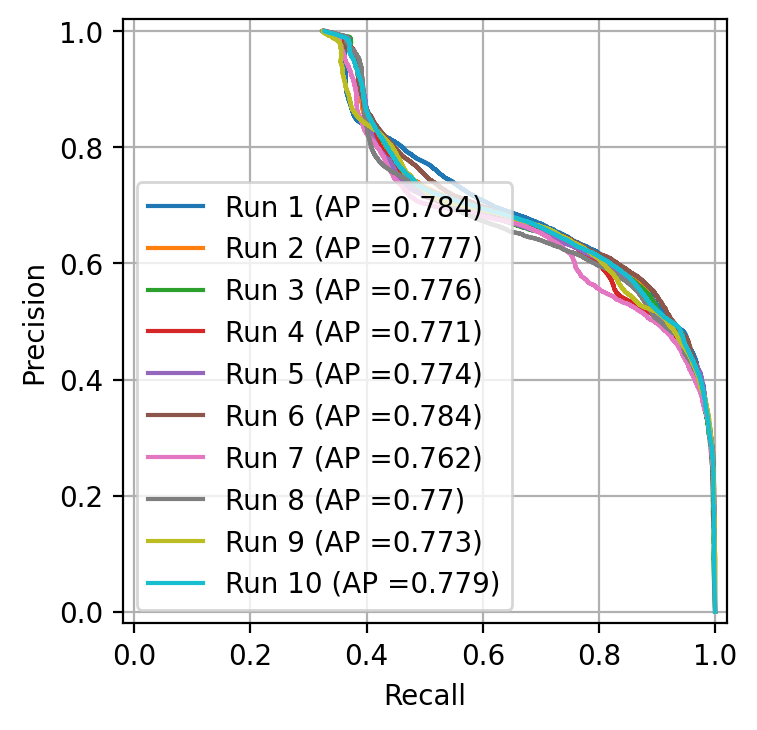

                          mean    std
average_precision_score  0.775  0.007
roc_auc_score            0.802  0.007


In [5]:
a_gcn = LinkPredictor(conv_cls=dgl.nn.GraphConv, skip_connections=False)

a_gcn_scores = cv_score_link_prediction(a_gcn, g, plot_pr_curve=True);

### ARes-GCN

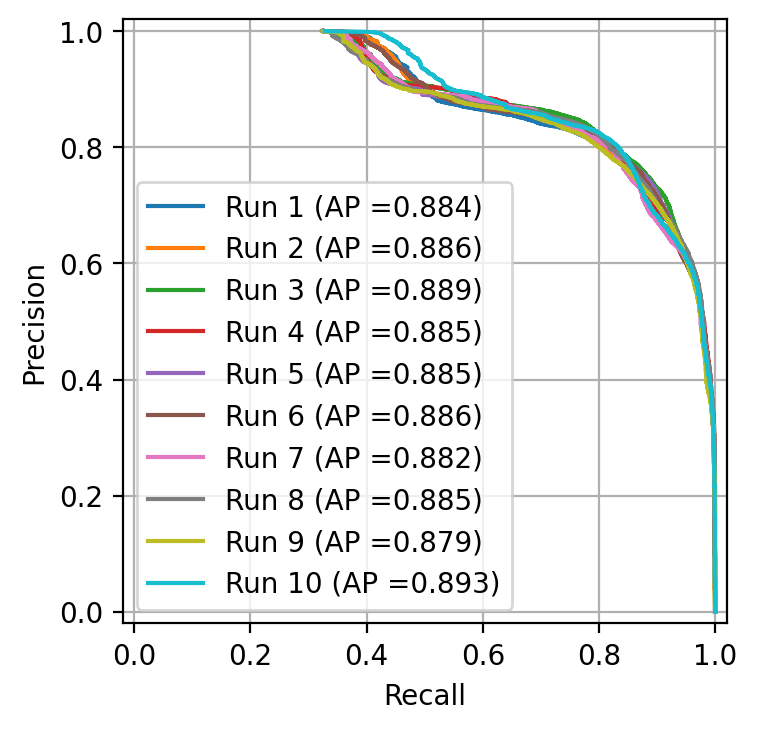

                          mean    std
average_precision_score  0.885  0.004
roc_auc_score            0.907  0.007


In [6]:
ares_gcn = LinkPredictor(conv_cls=dgl.nn.GraphConv)
ares_gcn_scores = cv_score_link_prediction(ares_gcn, g, plot_pr_curve=True);

### ABRes-GCN

/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning

/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning

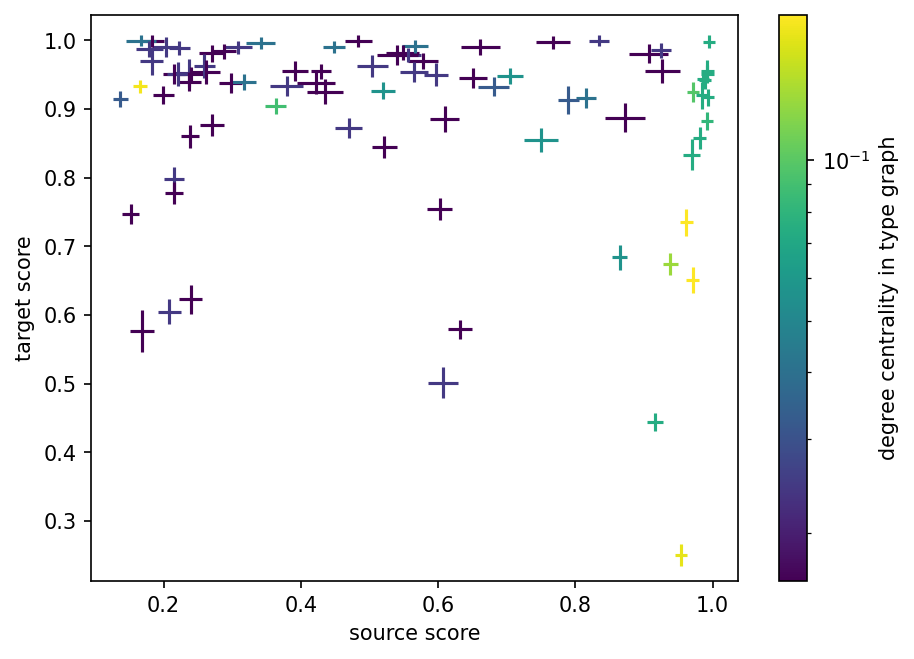

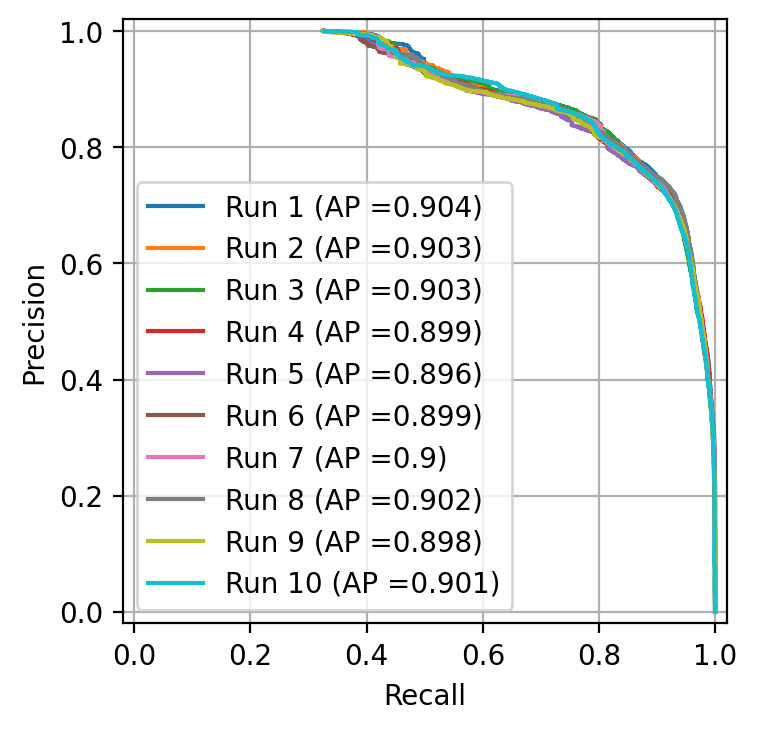

                          mean    std
average_precision_score  0.901  0.003
roc_auc_score            0.926  0.003


In [7]:
abres_gcn = LinkPredictor()
abres_gcn_scores = cv_score_link_prediction(abres_gcn, g, plot_pr_curve=True, plot_type_error=True)

### TatABRes-GCN

/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning

/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/wendling/anaconda3/envs/team/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning

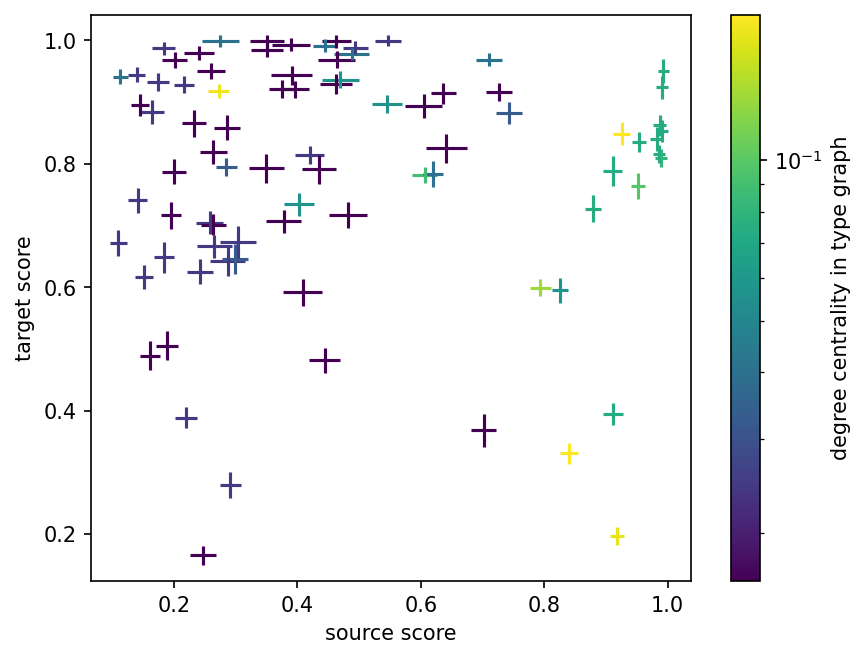

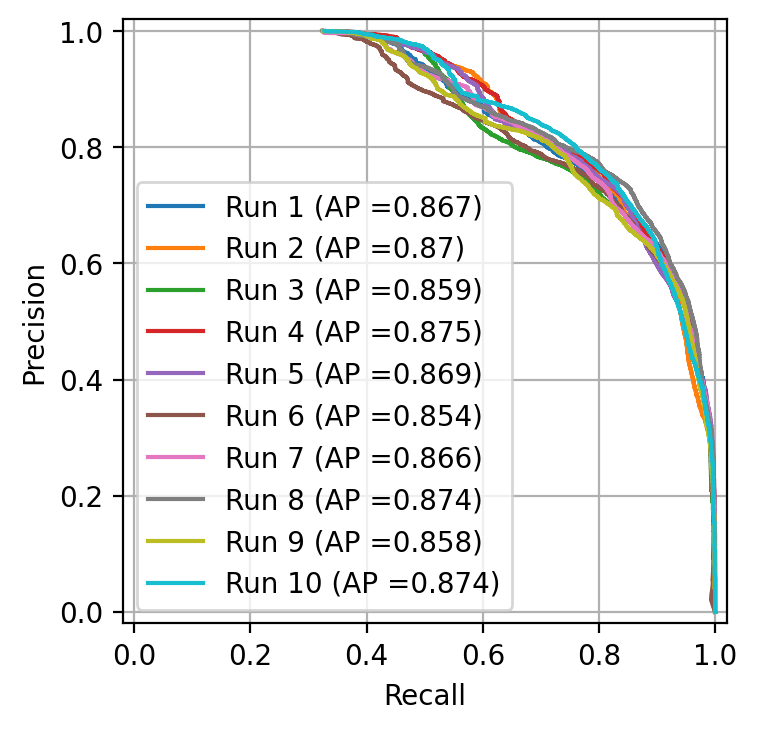

                          mean    std
average_precision_score  0.867  0.007
roc_auc_score            0.909  0.009


In [8]:
import nn

tatabres_gcn = LinkPredictor(conv_cls = nn.TypedMaskedGraphConv)
tatabres_gcn_scores = cv_score_link_prediction(tatabres_gcn, g, plot_pr_curve=True, plot_type_error=True)

### Comparison

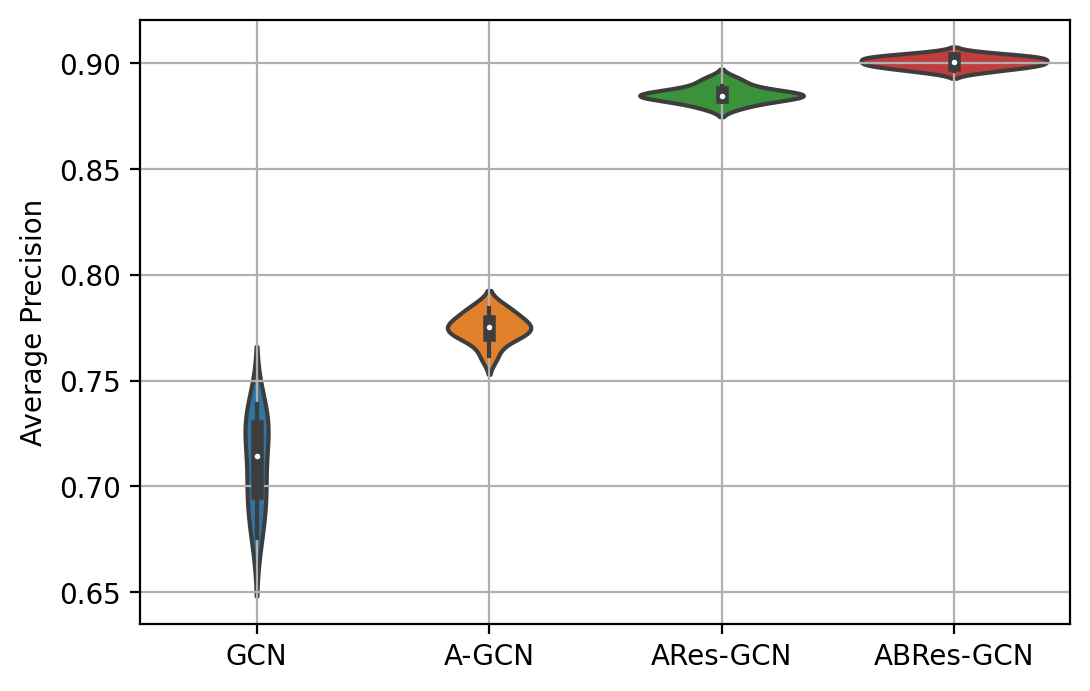

In [9]:
scores = [s['average_precision_score'] for s in [gcn_scores, a_gcn_scores, ares_gcn_scores, abres_gcn_scores]]
names = ['GCN', 'A-GCN', 'ARes-GCN', 'ABRes-GCN']
names = [[n]*len(scores) for n, scores in zip(names, scores)]

plt.figure(figsize=(6,4), dpi=200)
sns.violinplot(x=np.hstack(names), y=np.hstack(scores))
plt.grid(), plt.ylabel('Average Precision');

In [10]:
from scipy.stats import ttest_ind, ks_2samp

for i in range(1, len(scores)):
    print(names[i-1][0], names[i][0])
    print('\t', ttest_ind(scores[i-1], scores[i]))
    print('\t', ks_2samp(scores[i-1], scores[i]))

GCN A-GCN
	 Ttest_indResult(statistic=-8.921722968036075, pvalue=5.015004840789113e-08)
	 KstestResult(statistic=1.0, pvalue=1.0825088224469026e-05)
A-GCN ARes-GCN
	 Ttest_indResult(statistic=-45.304520556485784, pvalue=5.2814970228088634e-20)
	 KstestResult(statistic=1.0, pvalue=1.0825088224469026e-05)
ARes-GCN ABRes-GCN
	 Ttest_indResult(statistic=-10.684819016129854, pvalue=3.1922369567257307e-09)
	 KstestResult(statistic=1.0, pvalue=1.0825088224469026e-05)


## Ablation Studies

### Structure only

average_precision_score: 0.814	roc_auc_score: 0.834
average_precision_score: 0.813	roc_auc_score: 0.822
average_precision_score: 0.804	roc_auc_score: 0.823
average_precision_score: 0.808	roc_auc_score: 0.817
average_precision_score: 0.812	roc_auc_score: 0.827
average_precision_score: 0.811	roc_auc_score: 0.827
average_precision_score: 0.793	roc_auc_score: 0.804
average_precision_score: 0.81	roc_auc_score: 0.818
average_precision_score: 0.809	roc_auc_score: 0.831
average_precision_score: 0.794	roc_auc_score: 0.807


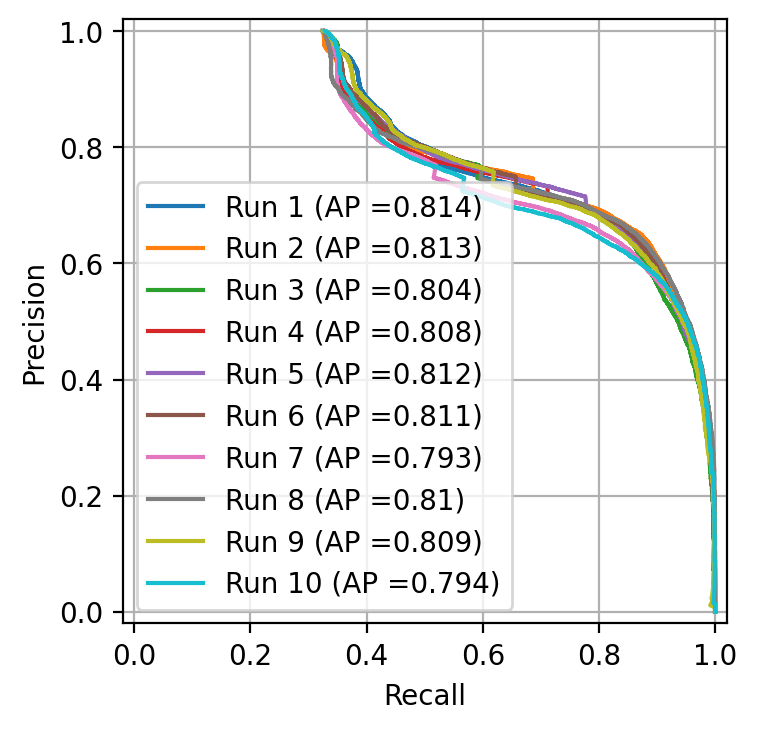

                          mean    std
average_precision_score  0.807  0.007
roc_auc_score            0.821  0.010


In [11]:
nx.set_node_attributes(g, values=1, name='dummy_label')
s_abres_gcn = LinkPredictor(node_feat_attr='dummy_label')
s_abres_gcn_scores = cv_score_link_prediction(s_abres_gcn, g, plot_pr_curve=True, verbose=True)

### GCN Layer Configuration

[16] False
                          mean    std
average_precision_score  0.874  0.002
roc_auc_score            0.913  0.002
[16, 16, 16] True
                          mean    std
average_precision_score  0.895  0.002
roc_auc_score            0.921  0.003
[16, 16, 16] False
                          mean    std
average_precision_score  0.843  0.011
roc_auc_score            0.867  0.013
[16, 16, 16, 16, 16] True
                          mean    std
average_precision_score  0.890  0.002
roc_auc_score            0.916  0.005
[16, 16, 16, 16, 16] False
                          mean    std
average_precision_score  0.832  0.007
roc_auc_score            0.860  0.006
[16, 16, 16, 16, 16, 16, 16] True
                          mean    std
average_precision_score  0.882  0.008
roc_auc_score            0.906  0.010
[16, 16, 16, 16, 16, 16, 16] False
                          mean    std
average_precision_score  0.810  0.028
roc_auc_score            0.843  0.023
[32] False
                     

<AxesSubplot:xlabel='layers', ylabel='score'>

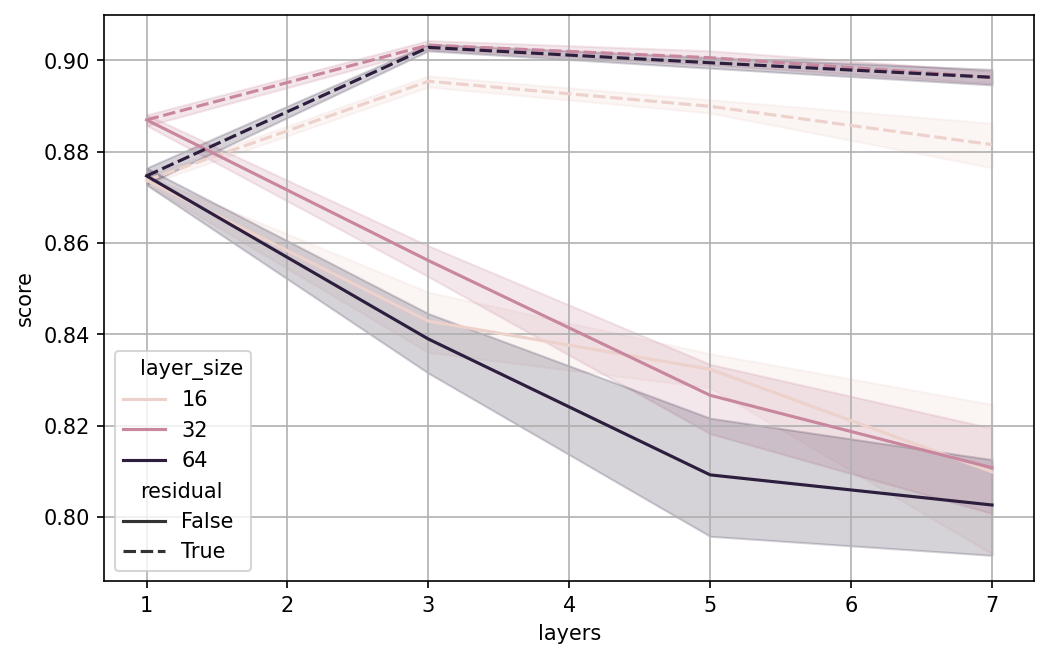

In [12]:
layer_df = []

for layer_size in (16, 32, 64):
    for num_layers in [1, 3, 5, 7]:
        for skip_connections in [True, False]:
            if skip_connections and num_layers < 3:
                continue
                
            est = LinkPredictor(layer_sizes = [layer_size]*num_layers, dropout=0.1, conv_cls = nn.BiGraphConv,
                               skip_connections=skip_connections)

            print([layer_size]*num_layers, skip_connections)
            scores = cv_score_link_prediction(est, g)['average_precision_score'];
            for score in scores:
                layer_df.append({'layers': num_layers, 'layer_size': layer_size, 'score':score,
                                'residual': skip_connections})

layer_df = pd.DataFrame(layer_df)
for layer_size, layers in np.unique(layer_df[['layer_size', 'layers']].values.T, axis=1).T:
    sub_df = layer_df[(layer_df.layer_size == layer_size) & (layer_df.layers == layers)]
    if True not in sub_df.residual.values:
        sub_df_ = sub_df.copy()
        sub_df_.residual = True
        layer_df = pd.concat([layer_df, sub_df_])

layer_df.to_csv('layer_configuration.csv')
plt.figure(figsize=(8, 5), dpi=150), plt.grid()
sns.lineplot(data=layer_df, x='layers', y='score', hue='layer_size', style='residual')